In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import optimize as opt
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
sample = pd.read_csv('data/part3data.txt', names=['Exam1', 'Exam2', 'Pass'])
sample.head()

,Exam1,Exam2,Pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


# Visualization

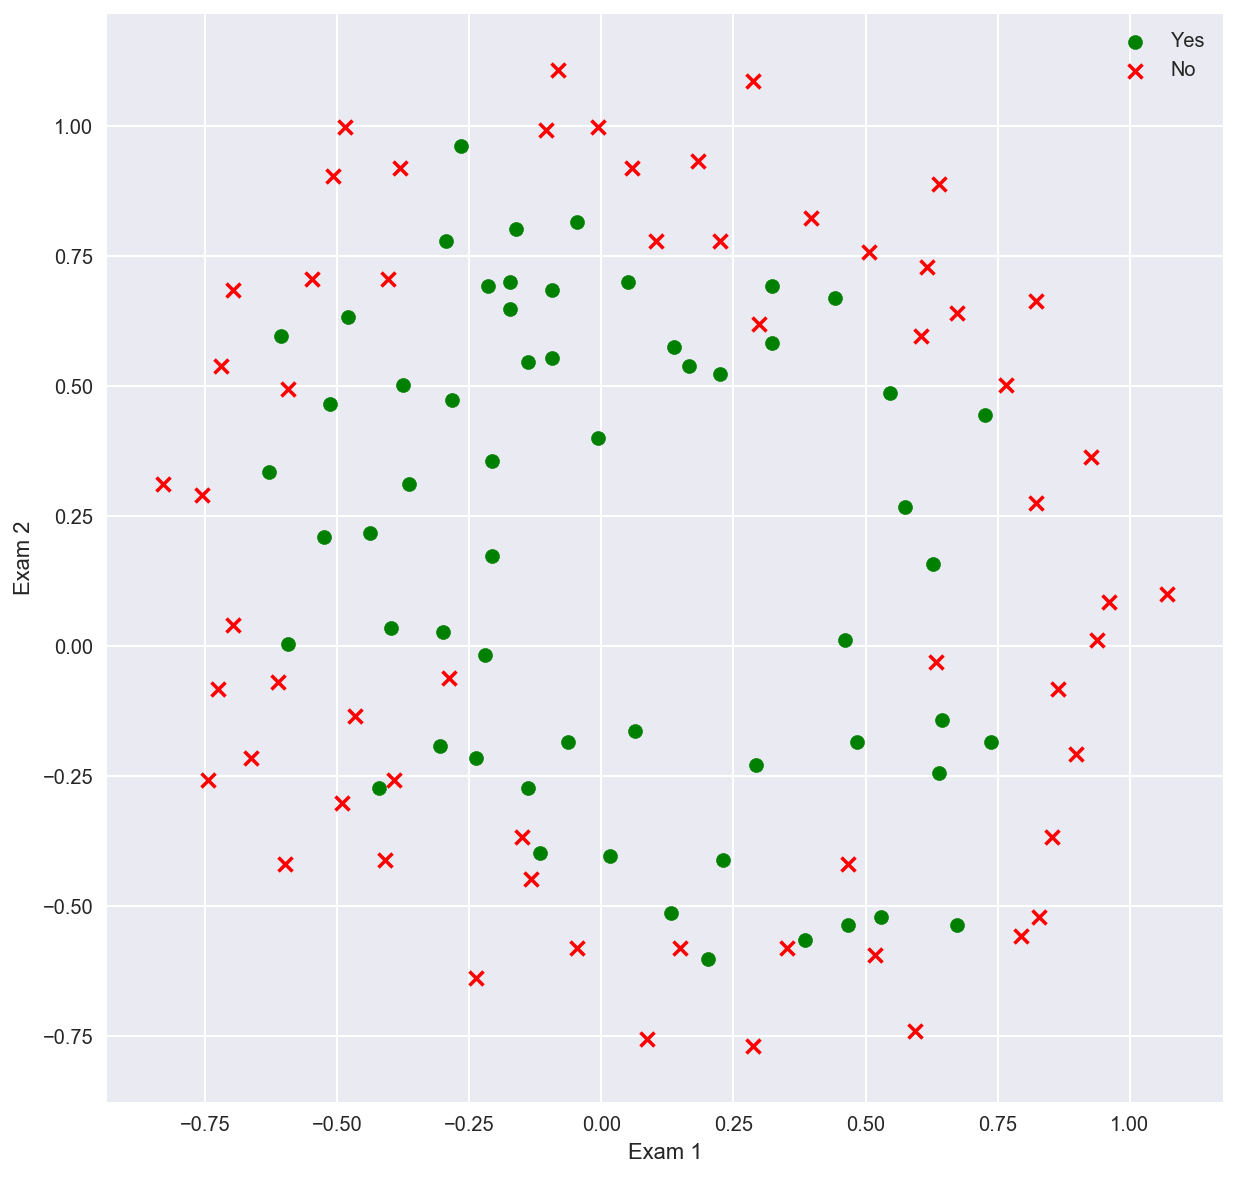

In [4]:
a = sample[ sample['Pass'] == 1 ]
b = sample[ sample['Pass'] == 0 ]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(a.ix[:, 0], a.ix[:, 1], marker='o', c='g')
ax.scatter(b.ix[:, 0], b.ix[:, 1], marker='x', c='r')
ax.set_xlabel('Exam 1')
ax.set_ylabel('Exam 2')
ax.legend(('Yes', 'No'))

# Logistic Regression

### sigmoid function
$f(x)=\frac{1}{1+e^{-x}}$

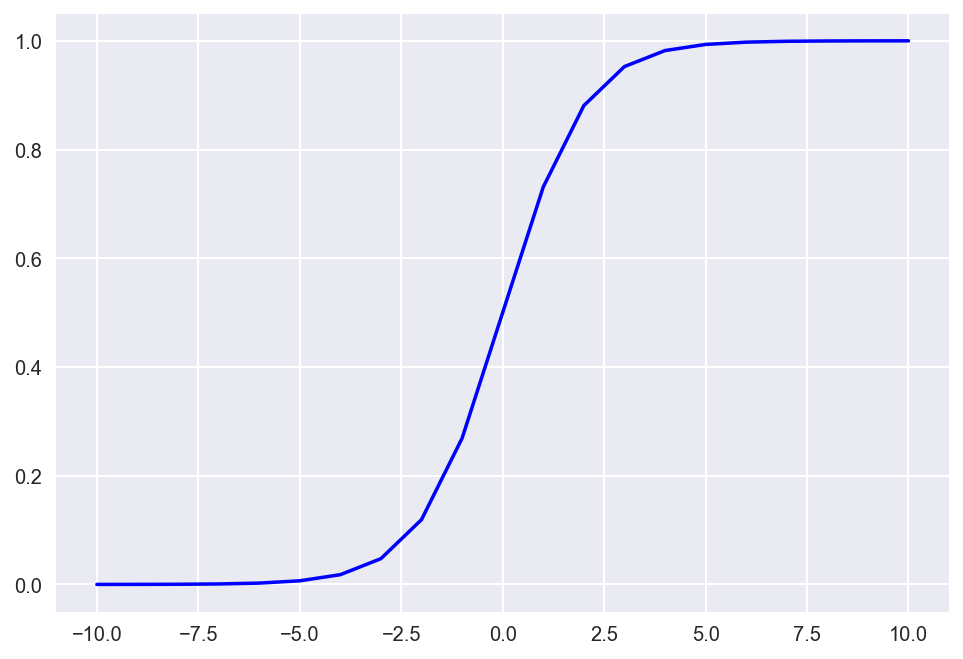

In [5]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

tempX = np.array(range(-10,11))
tempY = list( map(sigmoid, tempX) )
plt.plot(tempX, tempY, 'b')

### Feature Mapping

In [6]:
def mapFeature(x1, x2, degree):
    tmp = pd.DataFrame()
    tmp['one'] = np.ones(len(x1))
    
    for i in range(1, degree):  
        for j in range(0, i):
            tmp['x1' + str(i) + 'x2' + str(j)] = np.power(x1, i-j) * np.power(x2, j)
   
    return tmp

degree = 10
passData = sample['Pass']
newDataSet = mapFeature(sample['Exam1'], sample['Exam2'], degree)
newDataSet['Pass'] = passData

x = newDataSet.ix[:, :-1]
y = newDataSet.ix[:, -1:]

newDataSet.head()

,one,x11x20,x12x20,x12x21,x13x20,x13x21,x13x22,x14x20,x14x21,x14x22,...,x19x20,x19x21,x19x22,x19x23,x19x24,x19x25,x19x26,x19x27,x19x28,Pass
0,1.0,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,...,2.446477e-12,3.338322e-11,4.555282e-10,6.215876e-09,8.481827e-08,0.000001,0.000016,0.000216,0.002941,1
1,1.0,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,...,-5.075608e-10,3.748558e-09,-2.768473e-08,2.044638e-07,-1.510054e-06,0.000011,-0.000082,0.000608,-0.004493,1
2,1.0,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,...,-9.298729e-07,3.012047e-06,-9.756630e-06,3.160370e-05,-1.023708e-04,0.000332,-0.001074,0.003479,-0.011270,1
3,1.0,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,...,-1.466498e-04,1.963895e-04,-2.629995e-04,3.522020e-04,-4.716595e-04,0.000632,-0.000846,0.001133,-0.001517,1
4,1.0,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,...,-2.471500e-03,2.242239e-03,-2.034245e-03,1.845545e-03,-1.674349e-03,0.001519,-0.001378,0.001250,-0.001134,1


### Cost function
$$J(\theta) = - \frac{1}{m} \sum_{i=1}^m \large[ y^{(i)}\ \log (h_\theta (x^{(i)})) + (1 - y^{(i)})\ \log (1 - h_\theta(x^{(i)}))\large] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2$$

In [12]:
def cost(theta, x, y, landa):
    theta = np.matrix(theta)
    X = np.matrix(x)
    y = np.matrix(y)
    left = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    right = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = ( landa / (2 * len(X)) ) * np.sum( np.power(theta[:,1:theta.shape[1]], 2) )
    return np.sum(left - right) / (len(X)) + reg

### Gradient function

In [14]:
def gradient(theta, X, y, landa):  
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)

    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])

        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((landa / len(X)) * theta[:,i])

    return grad

### Minimize cost function using 'scipy' and 'BFGS' algorithm

In [17]:
x0 = np.zeros( (x.shape[1],1) )
landa = .0
res = opt.minimize(cost, x0,jac=gradient, method='BFGS', args=(x, y, landa), options={'disp': True})
print( res.x )

# res.x = np.array([ 0.35872309, -3.22200653, 18.97106363, -4.25297831, 18.23053189, 20.36386672, 8.94114455, -43.77439015, -17.93440473, -50.75071857, -2.84162964])
# print( res.x )

Optimization terminated successfully.
         Current function value: 0.283939
         Iterations: 534
         Function evaluations: 537
         Gradient evaluations: 537
[  7.39718037e-01   7.86567992e+00   6.36047036e+01  -1.61574422e+01
   1.96218886e+01   6.19025192e+01  -1.52969980e+02  -4.63759355e+02
   2.77614393e+02  -7.62803071e+01   2.91146864e+01  -3.72185035e+02
  -2.52474316e+01   6.80285867e+02   1.06814459e+02   6.78404717e+02
   1.28719601e+03  -1.11956713e+03   4.27200133e+02   1.43088699e+02
  -1.67873532e+02  -6.62577990e+02   8.01848568e+02  -2.27429475e+02
  -3.66523204e+02   2.65848577e+02  -3.68411214e+02  -1.54441653e+02
  -8.95837063e+02  -1.38239369e+03   1.02277574e+03  -3.07237327e+02
  -1.41486485e+02  -7.72992645e+02  -6.69708301e+02   2.97035452e+01
   1.41739634e+03  -2.39435957e+02   7.38817387e+01   3.02331292e+01
   4.52271588e+02  -8.96639387e+02  -9.47785968e+02  -1.60506310e+01
   1.56379143e+02  -4.05195194e+02]


### ترسیم مرز تصمیم - امتیازی

In [10]:
from mpl_toolkits.mplot3d import axes3d

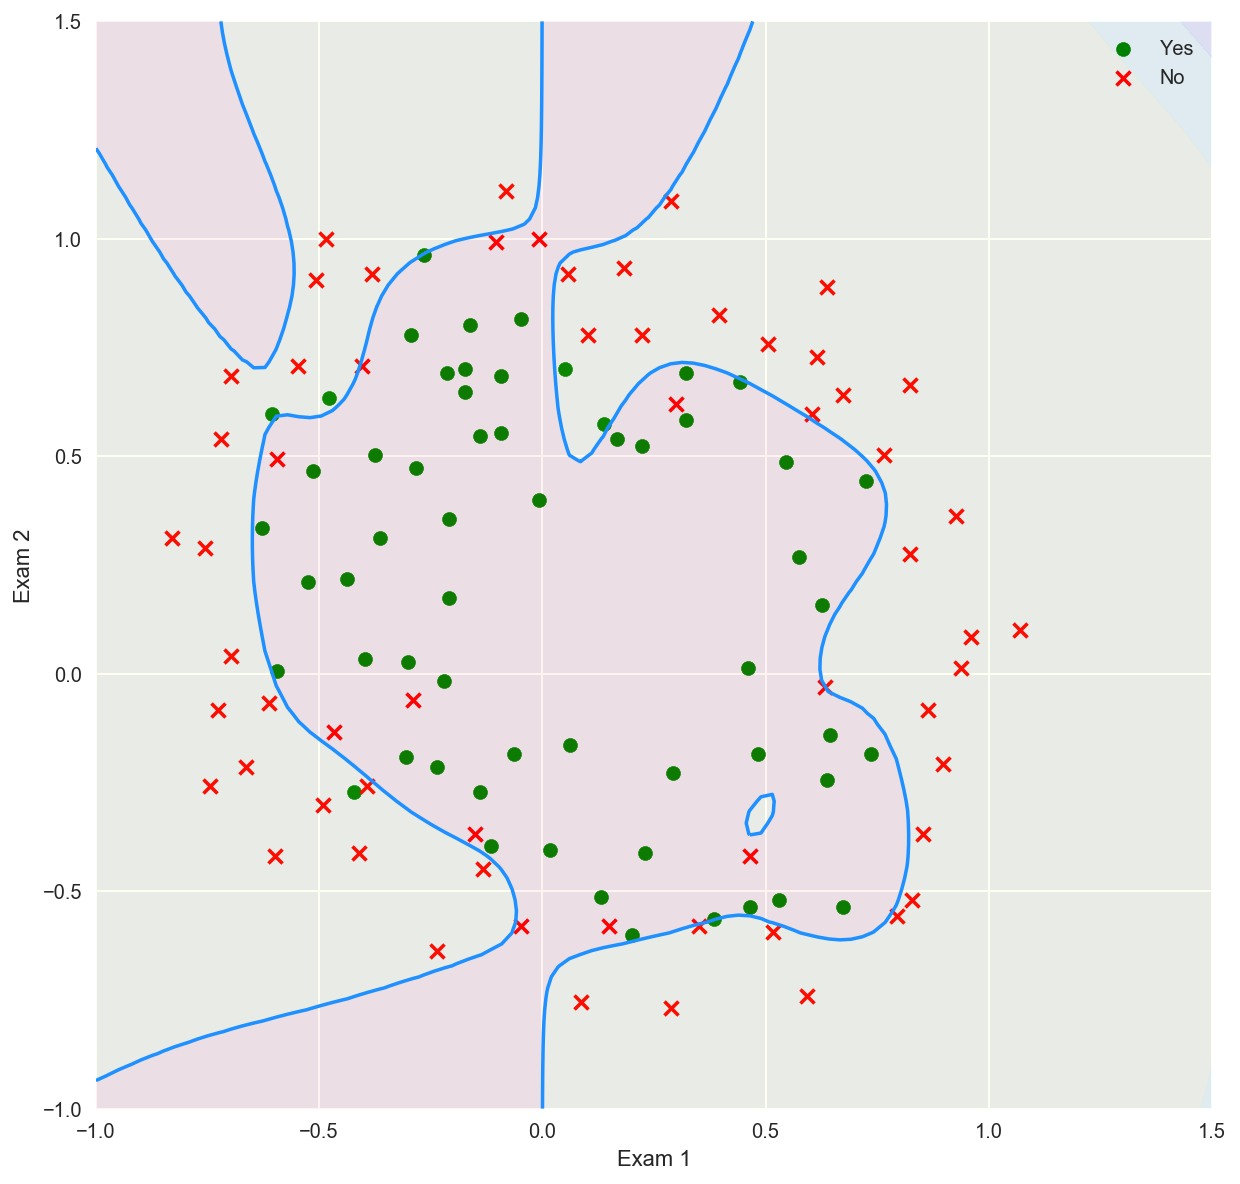

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(a.ix[:, 0], a.ix[:, 1], marker='o', c='g')
ax.scatter(b.ix[:, 0], b.ix[:, 1], marker='x', c='r')
ax.set_xlabel('Exam 1')
ax.set_ylabel('Exam 2')
ax.legend(('Yes', 'No'))

def plot_decision_boundary(ax, theta, X, y, degree):
    z = np.zeros([50, 50])
    uu = np.linspace(-1.0, 1.5, 50)
    vv = np.linspace(-1.0, 1.5, 50)
    
    for i, u in enumerate(uu):
        for j, v in enumerate(vv):
            z[i, j] = np.dot(mapFeature(np.array([[u]]), np.array([[v]]), degree), theta)[0]
    
    ax.contour(uu, vv, z.T, [0], colors='dodgerblue')
    plt.contourf(uu, vv, z.T, 2, alpha=.05, cmap='jet')

plot_decision_boundary(ax, res.x, x, y, degree)